In [4]:
from utils import load_embedding, parse_tup, cos_sim, cos_dist
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
tqdm.pandas()
TIME_FRAME = "monthly"

/h/224/cameron/miniconda3/envs/pyspark_env/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
embedding = load_embedding("/h/224/cameron/Political-Subreddit-Embedding/trained_embeddings/vecs_0.0028_15.0.txt",split=False)
embedding
print(embedding.loc["AskMen"])

1      0.217177
2      0.071641
3     -0.162866
4      0.141148
5     -0.100349
         ...   
146    0.096620
147    0.090875
148   -0.141013
149    0.152014
150    0.026513
Name: AskMen, Length: 150, dtype: float64


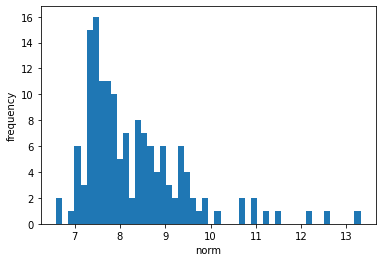

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(np.linalg.norm(embedding, axis=0), bins=50)
plt.ylabel("frequency")
plt.xlabel("norm")
plt.show()

In [38]:
from ipynb.fs.defs.Analogies import predict_analogies, score, get_possible_fits
religious_dim = [("Christianity","exchristian"),("TraditionalCatholics","excatholic"),("lds","exmormon"),("islam","exmuslim")]
def calculate_dim(dimensions,e):
    """
        Takes in a list of tuples and calcualtes the dimension from ap -> a. IE if we have the subreddits AskMen (a) and
        AskWomen (ap). The "masculine" vector transformation is a - ap.
        Returns the average transformation.
    """
    dimensions = dimensions if type(dimensions) is list else [dimensions]
    calc_trans = lambda vec_a,vec_ap : vec_a - vec_ap 
    transformations = np.array([calc_trans(e.loc[a],e.loc[ap]) for (a,ap) in dimensions])
    return np.mean(transformations,axis=0)

project_dim = lambda dim,sub,e : cos_sim(dim,e.loc[sub])
    
religious_dim = calculate_dim(religious_dim,embedding)
print("{} religious scale: {:.2f}".format("prolife",project_dim(religious_dim,"prolife",embedding)))
print("{} religious scale: {:.2f}".format("Conservative",project_dim(religious_dim,"Conservative",embedding)))
print("{} religious scale: {:.2f}".format("The_Donald",project_dim(religious_dim,"The_Donald",embedding)))
print("{} religious scale: {:.2f}".format("JoeBiden",project_dim(religious_dim,"JoeBiden",embedding)))
print("{} religious scale: {:.2f}".format("Pete_Buttigieg",project_dim(religious_dim,"Pete_Buttigieg",embedding)))
print("{} religious scale: {:.2f}".format("SandersForPresident",project_dim(religious_dim,"SandersForPresident",embedding)))
print("{} religious scale: {:.2f}".format("prochoice",project_dim(religious_dim,"prochoice",embedding)))

prolife religious scale: -0.08
Conservative religious scale: -0.08
The_Donald religious scale: -0.12
JoeBiden religious scale: 0.07
Pete_Buttigieg religious scale: -0.00
SandersForPresident religious scale: -0.09
prochoice religious scale: -0.08
